# Twitter Sentiment Analysis

## 1. Business Understanding
### Introduction
In today’s digital world, customers frequently share their opinions and experiences about technology products on social media platforms such as Twitter. For companies like **Apple** and **Google**, these real-time opinions provide valuable insights into how users perceive their products, services, and brand reputation. However, the sheer volume of tweets makes it difficult for businesses to manually analyze and understand overall customer sentiment.

This project addresses the challenge of **automatically analyzing Twitter sentiment** related to Apple and Google products. By building a machine learning model that can classify tweets as *positive, negative, or neutral*, businesses can gain a scalable and data-driven way to monitor public opinion.

### Stakeholders
Several stakeholders can benefit from this project:
- **Marketing Teams**: Track the effectiveness of new product launches, advertisements, and promotions by monitoring changes in sentiment over time.
- **Product Managers**: Identify customer pain points and areas for improvement in specific products or services.
- **Customer Support Teams**: Detect spikes in negative sentiment that may signal product issues or service disruptions requiring immediate response.
- **Executives and Business Strategists**: Use sentiment trends as part of decision-making for competitive positioning against rivals and for forecasting brand perception.

### Conclusion
By developing a sentiment analysis model for Apple and Google-related tweets, stakeholders gain a practical tool for understanding and responding to customer perceptions in real time. This capability helps companies stay competitive in the fast-paced technology industry by enabling **proactive decision-making**, **improved customer engagement**, and **data-driven product development**. Ultimately, the project demonstrates how Natural Language Processing (NLP) can turn unstructured social media data into actionable business intelligence.

## 2. Data Understanding
In this chapter, we explore the dataset to understand its source, structure, and properties.  
Data understanding is critical because it ensures we know what signals exist in the dataset, how reliable they are, and how they align with the business problem.  

Our goals in this chapter are to:
1. Load and preview the dataset.  
2. Check for missing values and duplicates.  
3. Understand dataset size and feature types.  
4. Explore descriptive statistics for text length and categories.  
5. Examine sentiment and product distributions.  
6. Identify limitations that impact modeling.  

By the end of this chapter, we will know what features are useful, what preprocessing steps are needed, and what challenges we must anticipate when modeling.

### Step 1: Load and Preview the Dataset

The first step in data understanding is to load the dataset into our environment and preview its structure.  
This helps us verify the columns, check for unexpected encodings, and see a snapshot of the content.  


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

FILE_PATH = "judge-1377884607_tweet_product_company.csv"

# Robust CSV loader to handle encodings
def load_csv(path):
    try:
        return pd.read_csv(path)
    except UnicodeDecodeError:
        return pd.read_csv(path, encoding="latin-1")

df = load_csv(FILE_PATH)

# Clean column names for consistency
df.columns = [c.strip().replace(" ", "_").lower() for c in df.columns]

# Preview first rows
display(df.head())
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


Shape: (9093, 3)
Columns: ['tweet_text', 'emotion_in_tweet_is_directed_at', 'is_there_an_emotion_directed_at_a_brand_or_product']


### Step 2: Inspect Dataset Info and Missing Values

Understanding column data types and missing values is essential.  
- It shows which columns are text, categorical, or numerical.  
- It helps us identify where imputation or cleaning may be needed.  

In [2]:
# Column types and non-null counts
df.info()

# Missing values per column
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

### Step 3: Check for Duplicates

Duplicate records can bias our model by overweighting certain examples.  
We check for duplicates to decide whether to drop or retain them.  


In [3]:
num_dupes = df.duplicated().sum()
print("Duplicate rows:", num_dupes)

Duplicate rows: 22


### Step 4: Rename Columns to Meaningful Names

For clarity, we rename columns into more readable names that align with our analysis:  
- `tweet_text` → tweet content (feature)  
- `emotion_in_tweet_is_directed_at` → product or brand (context feature)  
- `is_there_an_emotion_directed_at_a_brand_or_product` → sentiment label (target)

In [4]:
df = df.rename(columns={
    "tweet_text": "tweet_text",
    "emotion_in_tweet_is_directed_at": "product_or_brand",
    "is_there_an_emotion_directed_at_a_brand_or_product": "sentiment"
})
df.head()

,tweet_text,product_or_brand,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


### Step 5: Explore Descriptive Statistics of Text

Since tweets are unstructured text, we begin by measuring tweet length.  
- This helps us understand typical tweet size and whether there are unusually short or long tweets.  
- It also informs preprocessing choices, like truncation or padding in NLP models.  

In [5]:
# Robust text-length features that handle NaNs and non-strings

s = df["tweet_text"]  # [Series: one column of the DataFrame]

# Character count: .str.len() returns NaN for missing; we turn that into 0, then to int
df["tweet_len_char"] = s.str.len().fillna(0).astype("int64")  # [NaN: missing value; dtype: data type]

# Word count: split on whitespace, then count tokens; handle NaN the same way
df["tweet_len_word"] = s.str.split().str.len().fillna(0).astype("int64")

# Quick sanity check stats (count/mean/std/min/percentiles/max)
df[["tweet_len_char", "tweet_len_word"]].describe()


,tweet_len_char,tweet_len_word
count,9093.000000,9093.000000
mean,104.950731,17.763444
std,27.208419,4.964105
min,0.000000,0.000000
25%,86.000000,14.000000
50%,109.000000,18.000000
75%,126.000000,21.000000
max,178.000000,33.000000


### Step 6: Analyze Sentiment Distribution

The target variable is sentiment.  
We need to check the distribution to see if it is balanced, because imbalance can bias the model.  


In [6]:
sent_counts = df["sentiment"].value_counts()
sent_percent = (sent_counts / sent_counts.sum() * 100).round(2)

display(pd.DataFrame({"count": sent_counts, "percent": sent_percent}))

,count,percent
sentiment,,
No emotion toward brand or product,5389,59.27
Positive emotion,2978,32.75
Negative emotion,570,6.27
I can't tell,156,1.72


## Step 7: Analyze Product/Brand Distribution

Tweets also indicate which product or brand the sentiment is directed at.  
This is useful for:  
- Comparing sentiment across products (Apple vs Google).  
- Understanding which categories dominate the dataset.  


In [7]:
prod_counts = df["product_or_brand"].value_counts()
prod_percent = (prod_counts / prod_counts.sum() * 100).round(2)

display(pd.DataFrame({"count": prod_counts, "percent": prod_percent}))

,count,percent
product_or_brand,,
iPad,946,28.75
Apple,661,20.09
iPad or iPhone App,470,14.28
Google,430,13.07
iPhone,297,9.02
Other Google product or service,293,8.90
Android App,81,2.46
Android,78,2.37
Other Apple product or service,35,1.06


### Step 8: Visualize the Distributions

Visualization helps stakeholders quickly see imbalances and coverage.  
We’ll plot sentiment distribution, product frequency, and tweet lengths.

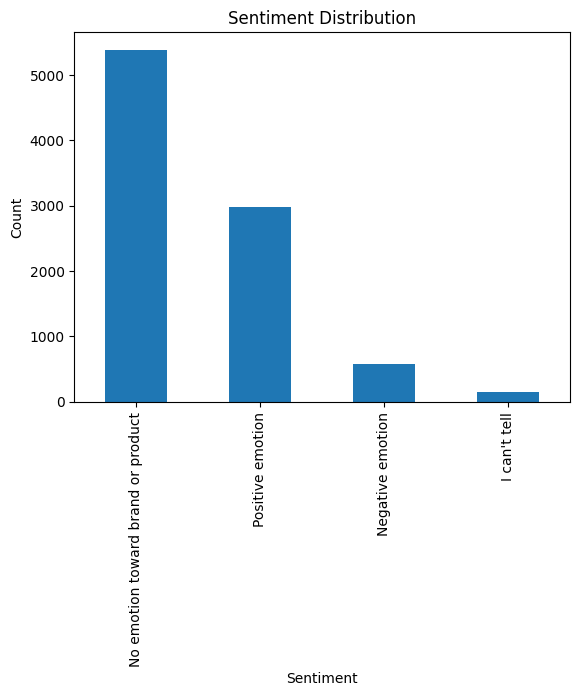

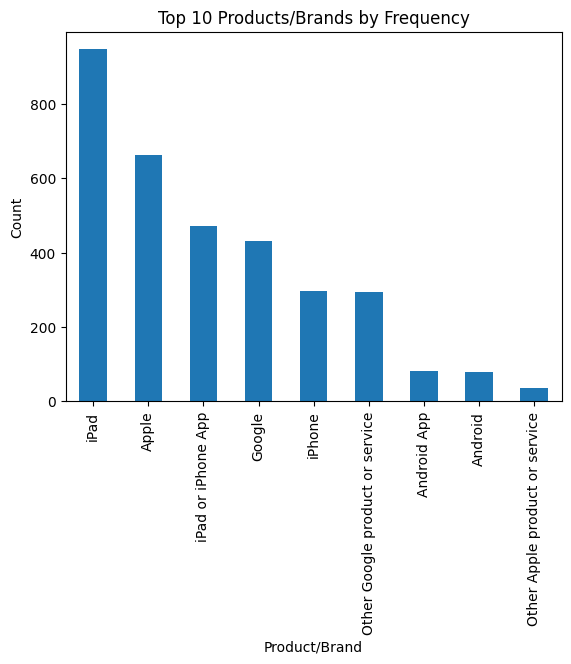

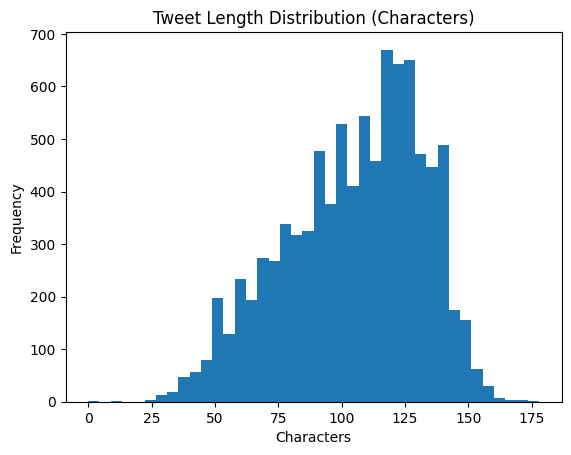

In [8]:
# Sentiment distribution
plt.figure()
sent_counts.plot(kind="bar")
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

# Product distribution (top 10)
plt.figure()
prod_counts.head(10).plot(kind="bar")
plt.title("Top 10 Products/Brands by Frequency")
plt.xlabel("Product/Brand")
plt.ylabel("Count")
plt.show()

# Tweet length histogram
plt.figure()
df["tweet_len_char"].plot(kind="hist", bins=40)
plt.title("Tweet Length Distribution (Characters)")
plt.xlabel("Characters")
plt.ylabel("Frequency")
plt.show()


## Step 9: Identify Limitations

From our analysis, we see some challenges:  
- **Imbalance**: “No emotion” dominates, risking bias in predictions.  
- **Noise**: “I can’t tell” adds ambiguity.  
- **Informal text**: Slang, hashtags, and URLs require preprocessing.  
- **Temporal drift**: Tweets are time-specific; sentiment changes with new product launches.  

These limitations guide our preprocessing and modeling strategy in the next chapter.